In [43]:
from numpy import *
from scipy import *
import numpy as np
from matplotlib import *

from scipy import integrate
from scipy import interpolate
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import xlrd

rc('text',usetex = True)
rc('font', family='serif',size = 12)

In [44]:
def Properties(C,dT,B_exp,K,B_l_int,B_h_int,T,N_ml): #Get the properties on the low and high field

    C_l = zeros([N_ml,len(T)])
    C_h = zeros([N_ml,len(T)])
    dT_l = zeros([N_ml,len(T)])
    dT_h = zeros([N_ml,len(T)])
    

    for i in range(K):
        #print(B_exp[i],B_h_int)
        if B_exp[i] == B_l_int:
            for j in range(N_ml):
                C_l[j][i]=C[j,i]
                dT_l[j][i]=dT[j,i]

        if B_exp[i] == B_h_int and B_exp[i-1]< B_h_int:
            A = i
        if B_exp[i] == B_h_int:
            for j in range(N_ml):
                C_h[j][i-A]=C[j,i]
                dT_h[j][i-A]=dT[j,i]
                
    return(C_l,C_h,dT_l,dT_h)

In [45]:
def SubMetrics(Th,Tc,T_l,T_layer,L_layer,C_h,C_l,dT_ad,dT_ad_d):

    #Th = 312
    #Tc = 282

    C_mag = []
    C_dmag = []
    dT_mag = []
    dT_dmag = []

    T_int = np.arange(Tc,Th+0.01,0.1)


    #T_layer = np.arange(282,310.1,30/(15))
    #L_layer = (100/len(T_layer))*ones(len(T_layer))
    N_l = len(T_layer)

    A = np.int((Tc - min(T_exp))/0.1)



    T_t = []
    L = 0

    for i in range(N_l):
        L = L + L_layer[i]
        T_tr = Tc + 0.001 +L/100*(Th-Tc)
        T_t.append(T_tr)
    
    
    k = 0    
    for i in range (len(T_int)):
        #print(T_int[i])
        if T_int[i] <=T_t[k]:
            #print(T_int[i],T_t[k])
            for j in range(len(T_l)):
                #print(T_layer[k],T_l[j])
                if T_layer[k] >= T_l[j] and T_layer[k] < T_l[j+1]:
                    #print('Hello')
                    #print(T_int[i],T_t[k],T_layer[k],T_l[j],T_l[j+1])
                    C_mag.append(C_h[j+1][int(i+A)]-(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    C_dmag.append(C_l[j+1][int(i+A)]-(C_l[j+1][int(i+A)]-C_l[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    dT_mag.append(dT_ad[j+1][int(i+A)]-(dT_ad[j+1][int(i+A)]-dT_ad[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    dT_dmag.append(dT_ad_d[j+1][int(i+A)]-(dT_ad_d[j+1][int(i+A)]-dT_ad_d[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    #print(T_int[i],C_h[j+1][int(i+A)],C_h[j][int(i+A)],(C_h[j+1][int(i+A)]-(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j])))
        else:
            for j in range(len(T_l)):
                if T_layer[k+1] >= T_l[j] and T_layer[k+1] < T_l[j+1]:
                    C_mag.append(C_h[j][int(i+A)]+(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    C_dmag.append(C_l[j][int(i+A)]+(C_l[j+1][int(i+A)]-C_l[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    dT_mag.append(dT_ad[j][int(i+A)]+(dT_ad[j+1][int(i+A)]-dT_ad[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    dT_dmag.append(dT_ad_d[j][int(i+A)]+(dT_ad_d[j+1][int(i+A)]-dT_ad_d[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    #print(T_int[i],C_h[j+1][int(i+A)],C_h[j][int(i+A)],T_l[j+1],T_l[j],T_layer[k],(C_h[j+1][int(i+A)]-(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j])))
            k = k + 1

            
    return (C_mag,C_dmag,dT_mag,dT_dmag)

In [46]:
def Parameters(C_mag,C_dmag,dT_mag,dT_dmag,T_int):

    C_mag_mean   = integrate.simps(C_mag,T_int)/(max(T_int)-min(T_int))
    C_dmag_mean  = integrate.simps(C_dmag,T_int)/(max(T_int)-min(T_int))
    
    dT_mag_mean  = integrate.simps(dT_mag,T_int)/(max(T_int)-min(T_int))
    dT_dmag_mean = integrate.simps(dT_dmag,T_int)/(max(T_int)-min(T_int))
    
    CdT_mag_mean   = integrate.simps(np.array(C_mag)*np.array(dT_mag),T_int)/(max(T_int)-min(T_int))
    CdT_dmag_mean  = integrate.simps(np.array(C_dmag)*np.array(dT_dmag),T_int)/(max(T_int)-min(T_int))
    return C_mag_mean, C_dmag_mean, dT_mag_mean,dT_dmag_mean,CdT_mag_mean,CdT_dmag_mean

In [47]:
def Metrics (SpecHeat,dTad,B_l_int,B_h_int,T_arg,N_ml,Th,Tc,T_l,T_layer,L_layer):
    (C_l,C_h,dT_l,dT_h) = Properties(C,dT,np.round(B_exp,2),K,B_l_int,B_h_int,T_arg,N_ml) #Properties of low and high fields
    dT_ad = np.array(dT_h)-np.array(dT_l)
             
    T_dem = zeros([N_ml,len(T_arg)])
    for j in range(N_ml):
        T_dem[j] = T_arg + dT_ad[j]
             
    dT_ad_d = np.zeros([N_ml,len(T_arg)])
    for i in range(N_ml):
        for j in range(len(T_arg)):
            for k in range(len(T_dem[i])):
                if  T_arg[j] > T_dem[i][k] and T_arg[j] <= T_dem[i][k+1]:
                    dT_ad_d[i][j] = (dT_ad[i][k] + (T_arg[j] - T_dem[i][k])*(dT_ad[i][k+1]-dT_ad[i][k])/(T_arg[k+1]-T_arg[k]))

    (C_mag,C_dmag,dT_mag,dT_dmag) = SubMetrics(Th,Tc,T_l,T_layer,L_layer,C_h,C_l,dT_ad,dT_ad_d)
    
    T_int = np.arange(Tc,Th+0.01,0.1)
    
    C_mag_mean, C_dmag_mean, dT_mag_mean,dT_dmag_mean,CdT_mag_mean,CdT_dmag_mean = Parameters(C_mag,C_dmag,dT_mag,dT_dmag,T_int)
    
    return C_mag_mean, C_dmag_mean, dT_mag_mean,dT_dmag_mean,CdT_mag_mean,CdT_dmag_mean

HEx inputs

In [48]:
def fan(V,a,b,c):
    P = a*V**2+b*V + c
    return P

In [49]:
N_r = 3
N_l = 4
Xt = 0.2
Xl = 0.3
L2 = N_r*Xl
L3 = Xt*N_l

In [8]:
L2,L3

(0.8999999999999999, 0.8)

In [9]:
if N_r%2 == 0:
    arranjo = 2
else:
    arranjo = 1

if arranjo == 0:
    N_t = L2*L3/(Xt*Xl)
elif arranjo == 1:
    N_t = (L3/Xt)*(L2/Xl+1)/2 + (L3/Xt-1)*(L2/Xl-1)/2
elif arranjo == 2:
    N_t = 0.5*(L2/Xl)*(2*L3/Xt-1)

In [10]:
arranjo,N_t

(1, 11.0)

In [11]:
def HEx(Xl,Xt,N_r,N_l,L1,Di,De,pf,xf,sigmaf,sigmah,pd,m_f,Nucleos):
    
    #Geometric definition
    #Xt = 0.0381
    #Xl = 0.033
    
    #N_r = 3
    L2 = N_r*Xl
    L3 = N_l*Xt
    
    #L2 = 0.033*4 #0.0215 #0.043
      #0.125 #0.152

    #Di = 0.01588 #694
    #De = 0.0163 #794


    
    #pf = 1/Beta
    #Nfin =100
    #Beta = Nfin/L1   #Fin density [1/m]
    
    #pf = 5*10**-3
    Beta = 1/pf
    Nfin = Beta*L1
    
    #xf = 0.007
    
    #sigmaf = 0.00015
    #sigmah = 0.0016
    
    #pd = 0.0018
    
    
    
    #Properties of air at 25ºC
    
    rho_a = 1.168      #[kg/m3] Density
    mu_a  = 0.00001849 #[kg/(m.s)] Viscosity
    cp_a  = 1004      #[kJ/kg.K] Specific heat
    Pr_a  = 0.7281     #[-] Prandtl number
    
    #Properties of the wall
    
    k_w = 273 #[W/m.K] Thermal conductivity of the aluminum
    
    #Properties of the water
    
    rho_w = 997        #[kg/m3] Density (25ºC)
    cp_w  = 4181       #[kJ/kg.K] Specific heat
    mu_wc = 0.001138   #[kg/(m.s)] Viscosity in the cold line (15ºC)
    mu_wh = 0.0007193  #[kg/(m.s)] Viscosity in the hot line (35ºC)
    Pr_wc = 8.092      #[-] Prandtl number in the cold line (15ºC)
    Pr_wh = 4.835      #[-] Prandtl number in the hot line  (35ºC)
    k_wc = 0.5888      #[-] Thermal conductivity in the cold line (15ºC)
    k_wh = 0.6217      #[-] Thermal conductivity in the hot line (35ºC)
    
    #Geometric calculation
    
    
    # Arranjo == 0 - Inline arrangement
    # Arranjo == 1 - Staggered Arrangement - Numero impar de fileiras - Última fila com o mesmo numero de tubos que a primeira
    # Arranjo == 2 - Staggered Arrangement - Numero par de fileiras   - Última fila com um tubo a menos que a primeira
    
    
    arranjo = 1
    
    N_t = N_r*N_l
    
    #print(L1,L2,L3,N_r,N_l,N_t,Nucleos)
    
    #if N_r%2 == 0:
        #arranjo = 2
    #else:
        #arranjo = 1
    
       
    #if arranjo == 0:
        #N_t = L2*L3/(Xt*Xl)
    #elif arranjo == 1:
        #N_t = (L3/Xt)*(L2/Xl+1)/2 + (L3/Xt-1)*(L2/Xl-1)/2
    #elif arranjo == 2:
        #N_t = 0.5*(L2/Xl)*(2*L3/Xt-1)
        
    
    dc = De + 2*sigmaf
    
    theta = np.arctan(pd/xf)


    
    
    if arranjo  == 0:
        A_min_o = ((Xt-De)*L1 - (Xt-De)*sigmaf*Beta*L1)*L3/Xt #Minimum free flow area
    else:
        a = ((Xt - De) - (Xt - De)*sigmaf*Beta)/2
        b = ((Xt/2)**2+Xl**2)**0.5 - De - (Xt-De)*sigmaf*Beta
        if a<b:
            c = 2*a
        else:
            c = 2*b
        A_min_o = ((L3/Xt-1)*c + (Xt-De)-(Xt-De)*sigmaf*Beta)*L1 #Minimum free flow area
    
    
    A_fr = L1*L3 #Frontal area
    sigma = A_min_o/A_fr
    
    
    A_p = np.pi*De*(L1-sigmaf*Beta*L1)*N_t+2*(L2*L3 - np.pi*De**2*N_t/4) #Primary surface area  - exposed tubes and header plates
    A_f = 2*(L2*L3-(np.pi*De**2/4)*N_t)*Beta*L1 + 2*L3*sigmaf*Beta*L1     #Secondary surface are - fin surface
    A_s = A_p + A_f       #Total heat transfer area
    A_t = np.pi*De*L1*N_t #External tube area
    
    sigma_o = (L3*L1 - L3*sigmaf*Beta*L1)/(L3*L1) #area concentration/expansion ratio
    D_h = 4*A_min_o*L2/A_s #Hydraulic diameter
    #print(D_h*1000,Beta,pf*1000)
    #Correlation parameters
    
    c1 = -0.1707 - 1.374*((Xl/sigmaf)**(-0.493))*((pf/dc)**(-0.886))*((N_r)**(-0.143))*((pd/xf)**(-0.0296))
    c2 = 0.1714 - 0.07372*((pf/Xl)**0.25)*(np.log(A_s/A_t))*((pd/xf)**(-0.2))
    c3 = 0.426*((pf/Xt)**0.3)*(np.log(A_s/A_t))
    
    VFR = np.arange(1,2000,1)
    dP_o = np.zeros(len(VFR))
    Rt_o = np.zeros(len(VFR))
    Re = np.zeros(len(VFR)) 
    for i in range(len(VFR)):
        vazao = VFR[i]*0.00047194745
        
        u_air = vazao/(L1*L3)
        u_max = u_air/sigma
        
        Re[i] = u_max*rho_a*dc/(mu_a)

        
        c4 = -10.2192/np.log(Re[i])
        
        
        #Pressure drop correlation
        f_o  = 0.05273*(Re[i]**c2)*((pd/xf)**c3)*((pf/Xt)**c4)*((np.log(A_s/A_t))**(-2.726))*(D_h/dc)**0.1325*((N_r)**0.02305)
        
        G_o = rho_a*u_max
        
        dP_o[i] = G_o**2/(2*rho_a)*((f_o)*(A_s/A_min_o))
        #Coulburn factor
        
        j_o = 1.7910*((Re[i])**c1)*((Xl/sigmaf)**(-0.456))*((N_r)**(-0.27))*((pf/dc)**(-1.343))*((pd/xf)**0.317)
        h_o = j_o*rho_a*u_max*cp_a*Pr_a**(-0.66666)
        
        #Fin efficiency
        
        m = ((2*h_o)/(k_w*sigmaf))**0.5
        
        Pm = Xt/2
        Pl = (((Xt/2)**2+Xl**2)**0.5)/2
        R_eq = 1.27*Pm*(Pl/Pm-0.3)**0.5
        phi = (R_eq/(Di/2)-1)*(1+0.35*np.log(R_eq/(Di/2)))
        eta = math.tanh(m*(Di/2)*phi)/(m*(Di/2)*phi)
        eta_o = 1 - (A_f/A_s)*(1-eta)
        
        Rt_o[i] = 1/(eta_o*h_o*A_s)
    
    
    
    #Internal flow
    
    Lh=(L1+2*sigmah)*N_t
    A_i = np.pi*Di*L1*N_t
    A_min_i = np.pi*(Di**2)/4
    G_i = m_f/A_min_i
    
    Re_ic = G_i*Di/mu_wc 
    Re_ih = G_i*Di/mu_wh
    
    A_c = (2.457*np.log(1/((7/Re_ic)**0.9+0.27*(0.0015*10**(-3)/Di))))**16
    B_c = (37530/Re_ic)**16
    
    A_h = (2.457*np.log(1/((7/Re_ih)**0.9+0.27*(0.0015*10**(-3)/Di))))**16
    B_h = (37530/Re_ih)**16
    
    f_c = (8*((8/Re_ic)**12 + (A_c + B_c)**(-3/2))**(1/12))/4
    f_h = (8*((8/Re_ih)**12 + (A_h + B_h)**(-3/2))**(1/12))/4
    
    if Re_ih < 2300:
        Nu_ih = 3.66
    else:
        Nu_ih = ((f_h/2)*(Re_ih-1000)*Pr_wh)/(1+12.7*((f_h/2)**0.5)*(Pr_wh**(2/3)-1))
                                              
    if Re_ic < 2300:
        Nu_ic = 3.66
    else:
        Nu_ic = ((f_c/2)*(Re_ic-1000)*Pr_wc)/(1+12.7*((f_c/2)**0.5)*(Pr_wc**(2/3)-1))   
    
    
    h_i_c = Nu_ic*k_wc/Di
    h_i_h = Nu_ih*k_wh/Di
       
    #print(Nu_ic, h_i_c,f_c,Re_ic)    
    
    Rt_i_c = 1/(h_i_c*A_i)
    Rt_i_h = 1/(h_i_h*A_i)
    
    K_bend = 26
    dP_i_c = f_c*G_i**2*4*(Lh/Di+N_t*np.pi*Xt/2/Di + N_t*K_bend)/(2*rho_w)  #f_c*G_i**2*4*50/(2*rho_w)
    dP_i_h = f_h*G_i**2*4*(Lh/Di+N_t*np.pi*Xt/2/Di + N_t*K_bend)/(2*rho_w) #f_c*G_i**2*4*50/(2*rho_w)
    #http://hydroneng.com/pipelines/
    #http://www.thermopedia.com/content/577/
    #print(200*f_c,np.pi*Xt/2,Lh)
                                              
    W_p_c = dP_i_c*m_f/rho_w
    W_p_h = dP_i_h*m_f/rho_w
    
    
    #Performance metrics
    
    UA_h = (Rt_o+Rt_i_h)**-1
    UA_c = (Rt_o+Rt_i_c)**-1
    #print(UA_h,UA_c)
    W_o = VFR*0.00047194745*dP_o/0.1
    
    NTU_c = UA_c/(VFR*0.00047194745*rho_a*cp_a)
    NTU_h = UA_h/(VFR*0.00047194745*rho_a*cp_a)
    
    C_r = (VFR*0.00047194745*rho_a*cp_a)/(m_f*cp_w)
    
    if N_r == 1:
        Eff_h = (1-np.exp(-C_r*(1-np.exp(-NTU_h))))/C_r
        Eff_c = (1-np.exp(-C_r*(1-np.exp(-NTU_c))))/C_r
    elif N_r == 2:
        K = (1-np.exp(-NTU_h/2))
        Eff_h = (1-np.exp(-2*K*C_r)*((1+C_r*K**2)))/C_r
        K = (1-np.exp(-NTU_c/2))
        Eff_c = (1-np.exp(-2*K*C_r)*((1+C_r*K**2)))/C_r
    elif N_r == 3:
        K = (1-np.exp(-NTU_h/3))
        Eff_h = (1-np.exp(-3*K*C_r)*(1+C_r*K**2*(3-K)+3*C_r**2*K**4/2))/C_r
        K = (1-np.exp(-NTU_c/3))
        Eff_c = (1-np.exp(-3*K*C_r)*(1+C_r*K**2*(3-K)+3*C_r**2*K**4/2))/C_r
    elif N_r ==4:
        K = (1-np.exp(-NTU_h/4))
        Eff_h = (1-np.exp(-4*K*C_r)*(1+C_r*K**2*(6-4*K+K**2)+4*C_r**2*K**4*(2-K)+8*C_r**3*K**6/3))/C_r
        K = (1-np.exp(-NTU_c/4))
        Eff_c = (1-np.exp(-4*K*C_r)*(1+C_r*K**2*(6-4*K+K**2)+4*C_r**2*K**4*(2-K)+8*C_r**3*K**6/3))/C_r
    else:
        Eff_h = 1 - np.exp(NTU_h**0.22*(np.exp(-C_r*NTU_h**0.78)-1)/C_r)
        Eff_c = 1 - np.exp(NTU_c**0.22*(np.exp(-C_r*NTU_c**0.78)-1)/C_r)
    
    
    
    ECr_c = Eff_c*C_r
    ECr_h = Eff_h*C_r
    
    #Fan
    
    #https://www.ebmpapst.com/en/products/axial-fans/axialfansdetail.php?pID=139216
    #https://www.ebmpapst.com/en/products/axial-fans/axialfansdetail.php?pID=128164
    
    dP_low = np.array([37,35,30,22,11,0]) 
    V_low  = np.array([1000,1250,1500,1750,2000,2250])*0.588578/Nucleos
    #V_low  = np.array([2500,2700,3000,3400,3700,4250])*0.588578/Nucleos
    
    #dP_low = np.array([40,30,20,10,0])
    #V_low = np.array([2000,2400,2700,3000,3250])*0.588578/Nucleos
    
    
    #dP_v = np.array([0,7,20,32,40,47,54])
    #V = np.array([2900,2750,2500,2250,2000,1750,1500])*0.588578
    
    
    #https://www.coolstore.pl/data/links/14dfdc7caabd364370879f08e2576560/4244_370.pdf
    #https://www.coolstore.pl/data/links/ebe5db23a298ac8d489ecac34f4111d0/4246_374.pdf
    
    dP_high = np.array([120,115,105,95,75,55,30,0])
    V_high  = np.array([2000,1500,2000,2500,3000,3500,4000,4500])*0.588578
    
    Coef_fan_l = curve_fit(fan,V_low,dP_low,maxfev=10000)
    Coef_fan_h = curve_fit(fan,V_high,dP_high,maxfev=1000)
    
    aux_low = fan(VFR,Coef_fan_l[0][0],Coef_fan_l[0][1],Coef_fan_l[0][2])-dP_o
    Inter_low = np.abs(aux_low).argmin()
    
    
    erro_dp = abs(dP_o[Inter_low] - fan(VFR[Inter_low],Coef_fan_l[0][0],Coef_fan_l[0][1],Coef_fan_l[0][2]))
    
    if erro_dp > 1:
        print(dP_o[Inter_low],fan(VFR[Inter_low],Coef_fan_l[0][0],Coef_fan_l[0][1],Coef_fan_l[0][2]))
    
    aux_high = fan(VFR,Coef_fan_h[0][0],Coef_fan_h[0][1],Coef_fan_h[0][2])-dP_o
    Inter_high = np.abs(aux_high).argmin() 
    
    #print(UA_c[Inter_low],Eff_c[Inter_low],C_r[Inter_low],m_f*3600,VFR[Inter_low],VFR[Inter_low]*Nucleos)

    return(W_o[Inter_low],ECr_c[Inter_low],ECr_h[Inter_low],dP_o[Inter_low],N_r,N_l,L1,pf,W_p_c,W_p_h,VFR[Inter_low],erro_dp,Eff_c[Inter_low],Eff_h[Inter_low])

In [12]:
HEx(27.5*10**-3,31.75*10**-3,1,5,0.11,0.00694,0.00794,4*10**-3,7*10**-3,0.15*10**-3, 0.00030,0.0018,150,1)

(80.64796608589468,
 4.1891558981266286e-05,
 4.189350357330923e-05,
 37.639506648282826,
 1,
 5,
 0.11,
 0.004,
 4081574508.1482077,
 4075351699.4919033,
 454,
 0.05851595900664819,
 0.10456152220779373,
 0.10456637591839865)

In [13]:
#Nucleos = np.array([1,2,4,8,16])
3040/Nucleos

NameError: name 'Nucleos' is not defined

In [14]:
sigmaf = 0.00010 #0.00015
sigmah = 0.00030 #0.0016
pd = 0.0018

Di = 0.0117
De = 0.0127

Nucleos = 7

#De = np.array(0.0127,0.01588,(0.01588-0.0127)/2)
#Di = De - 0.0015

#N_circuitos = 10

m_f = np.arange(4*640/3600/Nucleos,4*650/3600/Nucleos,4*5/3600/Nucleos) #3040/3600/Nucleos #

#Xt = np.arange(31.75*10**-3,1.01*38.1*10**-3,(38.1*10**-3-31.75*10**-3)/2)

Xt = (31.75*10**-3)

#Xl = np.arange(27.5*10**-3,1.01*33*10**-3,(33*10**-3-27.5*10**-3)/2)

Xl = 27.5*10**-3

pf = np.array([6,8,10,12,15])*10**-3#np.array([2.1,3.175,5.08,6.3])*10**-3 #np.array([2.1,2.54,3.175,4.2333,5.08,6.3])*10**-3 #np.arange(2.1*10**-3,1.01*6.3*10**-3,(6.3*10**-3-2.1*10**-3)/5) #min = 2.98 mm

N_r = np.arange(3,10.1,1)

#N_r = 3

N_l =[1,2]

#N_l = 30
L1  = np.arange(0.7,0.9,0.05) #np.arange(0.4,0.73,0.05)

#L1 = 0.8
#xf = np.arange(6.87*10**-3,1.01*8.25*10**-3,(8.25*10**-3-6.87*10**-3))

xf = 7*10**-3
#sigmaf = np.arange(0.00010,0.00021,0.00005)

sigmaf = 0.15*10**-3

In [15]:
W_l = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])
W_h = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])

W_p_h = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])
W_p_c = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])


ECr_c_l = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])
ECr_h_l = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])

E_c = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])
E_h = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])

In [16]:
ECr_c_h = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])
ECr_h_h = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])


print(size(W_l))

dP_o = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])
Nr= np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])
Nl = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])
L_1 = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])
p_f = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])
CFM = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])
erro_dp = np.zeros([size(m_f),size(Xl),size(Xt),size(N_r),size(N_l),size(L1),size(pf),size(xf),size(sigmaf)])

800


In [17]:
w = 0

for p in range(len(m_f)):
    for i in range(size(Xl)):
        for j in range(size(Xt)):
            for k in range(size(N_r)):
                for l in range(size(N_l)):
                    for m in range(size(L1)):
                        for n in range(size(pf)):
                            for o in range(size(xf)):
                                for q in range(size(sigmaf)):
                                    A,B,C,D,E,F,G,H,I,J,K,O,P,Q = HEx(Xl,Xt,N_r[k],N_l[l],L1[m],Di,De,pf[n],xf,sigmaf,sigmah,pd,m_f[p],Nucleos)
                                    
                                    W_l[p][i][j][k][l][m][n][o][q] = A
                                    ECr_c_l[p][i][j][k][l][m][n][o][q] = B
                                    ECr_h_l[p][i][j][k][l][m][n][o][q] = C
                                    E_c[p][i][j][k][l][m][n][o][q] = P
                                    E_h[p][i][j][k][l][m][n][o][q] = Q
                                    dP_o[p][i][j][k][l][m][n][o][q] = D
                                    
                                    Nr[p][i][j][k][l][m][n][o][q] = E
                                    Nl[p][i][j][k][l][m][n][o][q] = F
                                    L_1[p][i][j][k][l][m][n][o][q] = G
                                    p_f[p][i][j][k][l][m][n][o][q] = H
                                   
                                    
                                    W_p_h[p][i][j][k][l][m][n][o][q] = I
                                    W_p_c[p][i][j][k][l][m][n][o][q] = J
                                    CFM[p][i][j][k][l][m][n][o][q] = K
                                    erro_dp[p][i][j][k][l][m][n][o][q] = O
                                
                                    #print(F,G)
                                    w = w+1
                        print(w/size(W_l)*100)

0.625
1.25
1.875
2.5
3.125
3.75
4.375
5.0
5.625
6.25
6.875000000000001
7.5
8.125
8.75
9.375
10.0
10.625
11.25
11.875
12.5
13.125
13.750000000000002
14.374999999999998
15.0
15.625
16.25
16.875
17.5
18.125
18.75
19.375
20.0
20.625
21.25
21.875
22.5
23.125
23.75
24.375
25.0
25.624999999999996
26.25
26.875
27.500000000000004
28.125
28.749999999999996
29.375
30.0
30.625000000000004
31.25
31.874999999999996
32.5
33.125
33.75
34.375
35.0
35.625
36.25
36.875
37.5
38.125
38.75
39.375
40.0
40.625
41.25
41.875
42.5
43.125
43.75
44.375
45.0
45.625
46.25
46.875
47.5
48.125
48.75
49.375
50.0
50.625
51.24999999999999
51.87500000000001
52.5
53.125
53.75
54.37499999999999
55.00000000000001
55.625
56.25
56.875
57.49999999999999
58.12500000000001
58.75
59.375
60.0
60.62499999999999
61.25000000000001
61.875
62.5
63.125
63.74999999999999
64.375
65.0
65.625
66.25
66.875
67.5
68.125
68.75
69.375
70.0
70.625


KeyboardInterrupt: 

In [ ]:
#L1,L2,L3,Xl,N_l,N_t,Nucleo

In [ ]:
print(L1,L2,L3,Xl,Xt,N_r,N_l)

In [ ]:
W_array_L = np.zeros([size(m_f),np.int(size(W_l)/size(m_f))])
Ec_array_L = np.zeros([size(m_f),np.int(size(W_l)/size(m_f))])
Eh_array_L = np.zeros([size(m_f),np.int(size(W_l)/size(m_f))])

E_array_h = np.zeros([size(m_f),np.int(size(W_l)/size(m_f))])
E_array_c = np.zeros([size(m_f),np.int(size(W_l)/size(m_f))])
dP_o_array_L = np.zeros([size(m_f),np.int(size(W_h)/size(m_f))])

Nr_array = np.zeros([size(m_f),np.int(size(W_h)/size(m_f))])
Nl_array = np.zeros([size(m_f),np.int(size(W_h)/size(m_f))])
L1_array = np.zeros([size(m_f),np.int(size(W_h)/size(m_f))])
pf_array = np.zeros([size(m_f),np.int(size(W_h)/size(m_f))])

W_array_H = np.zeros([size(m_f),np.int(size(W_h)/size(m_f))])
Ec_array_H = np.zeros([size(m_f),np.int(size(W_h)/size(m_f))])
Eh_array_H = np.zeros([size(m_f),np.int(size(W_h)/size(m_f))])

W_p_h_array = np.zeros([size(m_f),np.int(size(W_h)/size(m_f))])
W_p_c_array = np.zeros([size(m_f),np.int(size(W_l)/size(m_f))])

Nr_array = np.zeros([size(m_f),np.int(size(W_h)/size(m_f))])
Nl_array = np.zeros([size(m_f),np.int(size(W_h)/size(m_f))])
L1_array = np.zeros([size(m_f),np.int(size(W_h)/size(m_f))])
pf_array = np.zeros([size(m_f),np.int(size(W_h)/size(m_f))])
CFM_array = np.zeros([size(m_f),np.int(size(W_h)/size(m_f))])
erro_array = np.zeros([size(m_f),np.int(size(W_h)/size(m_f))])

In [ ]:
w=0

for p in range(size(m_f)):
    for i in range(size(Xl)):
        for j in range(size(Xt)):
            for k in range(size(N_r)):
                for l in range(size(N_l)):
                    for m in range(size(L1)):
                        for n in range(size(pf)):
                            for o in range(size(xf)):
                                for q in range(size(sigmaf)):
                                    W_array_L[p][w-p*np.int(size(W_l)/size(m_f))] = W_l[p][i][j][k][l][m][n][o][q]
                                    Ec_array_L[p][w-p*np.int(size(W_l)/size(m_f))] = ECr_c_l[p][i][j][k][l][m][n][o][q]
                                    Eh_array_L[p][w-p*np.int(size(W_l)/size(m_f))] = ECr_h_l[p][i][j][k][l][m][n][o][q]
                                    E_array_h[p][w-p*np.int(size(W_l)/size(m_f))] = E_c[p][i][j][k][l][m][n][o][q]
                                    E_array_c[p][w-p*np.int(size(W_l)/size(m_f))] = E_h[p][i][j][k][l][m][n][o][q]
                                    dP_o_array_L[p][w-p*np.int(size(W_h)/size(m_f))] = dP_o[p][i][j][k][l][m][n][o][q]
                                    
                                    Nr_array[p][w-p*np.int(size(W_h)/size(m_f))] = Nr[p][i][j][k][l][m][n][o][q]
                                    Nl_array[p][w-p*np.int(size(W_h)/size(m_f))] = Nl[p][i][j][k][l][m][n][o][q]
                                    L1_array[p][w-p*np.int(size(W_h)/size(m_f))] = L_1[p][i][j][k][l][m][n][o][q]
                                    pf_array[p][w-p*np.int(size(W_h)/size(m_f))] = p_f[p][i][j][k][l][m][n][o][q]
                                    
                                    W_p_h_array[p][w-p*np.int(size(W_h)/size(m_f))] = W_p_h[p][i][j][k][l][m][n][o][q]
                                    W_p_c_array[p][w-p*np.int(size(W_l)/size(m_f))] = W_p_c[p][i][j][k][l][m][n][o][q]
                                    CFM_array[p][w-p*np.int(size(W_l)/size(m_f))] = CFM[p][i][j][k][l][m][n][o][q]
                                    erro_array[p][w-p*np.int(size(W_l)/size(m_f))] = erro_dp[p][i][j][k][l][m][n][o][q]
                                    
                                    Nr_array[p][w-p*np.int(size(W_h)/size(m_f))] = N_r[k]
                                    # Nl_array[p][w-p*np.int(size(W_h)/size(m_f))] = N_l[l]
                                    L1_array[p][w-p*np.int(size(W_h)/size(m_f))] = L1[m]
                                    pf_array[p][w-p*np.int(size(W_h)/size(m_f))] = pf[n]

                    
                                    w = w+1
                                    #print(p,i,j,k,l,m,n,o,q)

In [ ]:
for i in range(len(m_f)):
    plt.plot(Nucleos*CFM_array[i]*0.00047194745*1.168*1004,'o')

In [ ]:
#plt.plot(erro_array[0],'o')
#plt.plot(erro_array[1],'o')
#plt.plot(erro_array[2],'o')
#plt.plot(erro_array[3],'o')
#plt.plot(erro_array[4],'o')

In [ ]:
for i in range(len(m_f)):
    plt.plot(CFM_array[i],'o')
plt.ylim(0,1500)

In [ ]:
len(E_array_c[i]*Nucleos*CFM_array[i]*0.00047194745*1.168*1004)

for i in range(size(m_f)):
    plt.plot(np.array(W_t_L[i])*Nucleos,E_array_c[i]*Nucleos*CFM_array[i]*0.00047194745*1.168*1004,'.')
plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$\epsilon C_\mathrm{r}$ [-]')
#plt.xlim([0,2000])
plt.show()

In [ ]:
for i in range(size(m_f)):
    plt.plot(CFM_array[i]*Nucleos,Ec_array_L[i],'.')

In [ ]:
len(W_t_L[i]),Nucleos

In [ ]:
W_t_L = W_array_L+W_p_h_array/0.9
#W_t_H = 2*W_array_H+W_p_h_array/0.9+W_p_c_array/0.9


for i in range(size(m_f)):
    plt.plot(np.array(W_t_L[i])*Nucleos,Ec_array_L[i],'.') #+ , label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[i]*3600,0)' [kg/h] - Low Fan')
    #plt.plot(W_t_L_2[4],Ec_array_2[4],'.', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[i]*3600,0)) + ' [kg/h] - Low Fan')
    #plt.plot(W_t_H[i],Ec_array_H[i],'.', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[i]*3600,0)) + ' [kg/h] - High Fan')
#plt.legend(bbox_to_anchor=(1, 1))
#plt.legend()
plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$\epsilon C_\mathrm{r}$ [-]')
#plt.xlim([0,2000])
plt.show()

In [ ]:
W_t_L = W_array_L+W_p_h_array/0.9

#plt.plot(W_p_h_array/W_p_c_array,'o')

In [ ]:
Ec_p_L = [[] for i in range(len(m_f))]
W_p_L = [[] for i in range(len(m_f))]
W_p_LA = [[] for i in range(len(m_f))]
W_p_LW = [[] for i in range(len(m_f))]

pf_p = []
Nr_p = []
Nl_p = []
L1_p = []

Ec_p_T = []
W_p_T =[]
W_p_W =[]
W_p_A =[]
m_f_T = []
CFM_p = []

for k in range(size(m_f)):
    for i in range(len(Ec_array_L[k])):
        A = 0
        for j in  range(len(Ec_array_L[k])):
            if Ec_array_L[k][i] < Ec_array_L[k][j] and W_t_L[k][i] > W_t_L[k][j]:
                #print(i,j)
                A = 1
                #break
        if A == 0 :
            Ec_p_L[k].append(Ec_array_L[k][i])
            W_p_L[k].append(W_t_L[k][i])
            W_p_LA[k].append(W_array_L[k][i])
            W_p_LW[k].append(W_p_h_array[k][i]/0.9)
            
            
            
            if Ec_array_L[k][i]>0.04 and W_t_L[k][i] < 3000 :
                Ec_p_T.append(Ec_array_L[k][i])
                CFM_p.append(CFM_array[k][i])
                W_p_T.append(W_t_L[k][i]*Nucleos)
                W_p_W.append(W_p_h_array[k][i]/0.9*Nucleos)
                W_p_A.append(W_array_L[k][i]*Nucleos)
                m_f_T.append(m_f[k])
                pf_p.append(pf_array[k][i])
                Nr_p.append(Nr_array[k][i])
                Nl_p.append(Nl_array[k][i])
                L1_p.append(L1_array[k][i])

In [ ]:
plt.plot(Ec_p_T,np.array(CFM_p)*24/np.array(Nl_p),'o')

In [ ]:
import xlsxwriter

workbook = xlsxwriter.Workbook('HEx.xlsx')
Data = workbook.add_worksheet('Data')
#C = workbook.add_worksheet('C')

for i in range(len(m_f_T)):
    Data.write(i,0,m_f_T[i]*3600) 
    Data.write(i,1,Ec_p_T[i])
    Data.write(i,2,W_p_T[i])
    Data.write(i,3,W_p_A[i])
    Data.write(i,4,W_p_W[i])
    Data.write(i,5,pf_p[i])
    Data.write(i,6,Nr_p[i])
    Data.write(i,7,Nl_p[i])
    Data.write(i,8,L1_p[i])
    Data.write(i,9,CFM_p[i]*Nucleos)

workbook.close()

Ec_p_H = [[] for i in range(len(m_f))]
W_p_H = [[] for i in range(len(m_f))]

Ec_p_T_H = []
W_p_T_H =[]
m_f_T_H = []

for k in range(size(m_f)):
    for i in range(len(Ec_array_H[k])):
        A = 0
        for j in  range(len(Ec_array_H[k])):
            if Ec_array_H[k][i] < Ec_array_H[k][j] and W_t_H[k][i] > W_t_H[k][j]:
                #print(i,j)
                A = 1
                #break
        if A == 0 :
            Ec_p_H[k].append(Ec_array_H[k][i])
            W_p_H[k].append(W_t_H[k][i])
            if Ec_array_H[k][i]>0.04 and W_t_H[k][i] < 2000 :
                Ec_p_T_H.append(Ec_array_H[k][i])
                W_p_T_H.append(W_t_H[k][i])
                m_f_T_H.append(m_f[k])

In [ ]:
plt.plot(W_t_L[0],Ec_array_L[0],'o')
#plt.plot(np.array(W_p_L[1])-np.array(W_p_LW[1]) - np.array(W_p_LA[1]),'.')
plt.plot()

In [ ]:
#W_t_L = 2*W_array_L+W_p_h_array_L/0.9+W_p_c_array_L/0.9
#for i in range(size(m_f)):
plt.plot(np.array(W_t_L[0])*Nucleos[0],Ec_array_L[0],'x', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[0]*3600,0)) + ' [kg/h]')
    #plt.plot(W_p_F[i],Ec_p_F[i],'.', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[i]*3600,0)) + ' [kg/h]')
plt.legend(bbox_to_anchor=(1, 1))
plt.legend()
plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$\epsilon C_\mathrm{r}$ [-]')
plt.xlim([0,1000])
#plt.show()
plt.savefig('ECr_Wt.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
plt.plot(np.array(W_p_L[i])*Nucleos,Ec_p_L[i])

In [ ]:
for i in range(size(m_f)):
    plt.plot(np.array(W_p_L[i])*Nucleos,Ec_p_L[i],'.') #, label = 'N$_\mathrm{circ}$ = ' + str(np.round(Nucleos[i]))
    #plt.plot(np.array(W_p_L[i])*Nucleos,np.array(W_p_W)*Nucleos,'.')
    #plt.plot(np.array(W_p_L[0])*Nucleos,Ec_p_L[0],'.', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[0]*3600,0)) + ' [kg/h]')
    #plt.plot(np.array(W_p_L[74])*Nucleos,Ec_p_L[74],'.', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[74]*3600,0)) + ' [kg/h]')

#plt.plot(W_p_H[i],Ec_p_H[i],'.', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[i]*3600,0)) + ' [kg/h] - High')
#plt.legend(bbox_to_anchor=(1, 1))
#plt.legend()
plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$\epsilon C_\mathrm{r}$ [-]')
#plt.xlim([0,200])
#plt.ylim(0.025,0.2)
#plt.show()
plt.savefig('ECr_Wt_Pareto_Multi_C.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
plt.plot(Nucleos[0]*np.array(W_p_L[0]),Ec_p_L[0],'.', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[0]*3600,0)) + ' [kg/h] - Low')
plt.plot(Nucleos[1]*np.array(W_p_L[1]),Ec_p_L[1],'.', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[1]*3600,0)) + ' [kg/h] - Low')
plt.plot(Nucleos[2]*np.array(W_p_L[2]),Ec_p_L[2],'.', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[2]*3600,0)) + ' [kg/h] - Low')
plt.plot(Nucleos[3]*np.array(W_p_L[3]),Ec_p_L[3],'.', label = '$\dot{m}_\mathrm{f}$ = ' + str(np.round(m_f[3]*3600,0)) + ' [kg/h] - Low')
plt.legend(bbox_to_anchor=(1, 1))
plt.legend()
plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$\epsilon C_\mathrm{r}$ [-]')
plt.xlim([50,500])
#plt.show()
plt.savefig('ECr_Wt_Pareto.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
def Paretto_HEx(X,a,b,c,d,e,f):
    P1,P2= X
    return (a*P1**b*P2**c+d*P1**1 + f*P2**1)  

In [ ]:
Paret_Hex = curve_fit(Paretto_HEx,(m_f_T,W_p_T),Ec_p_T,maxfev=1000000)
Paret_Hex

In [ ]:
plt.plot(W_p_T,Ec_p_T,'o',label = 'Numerical')
plt.plot(np.array(W_p_W) +np.array(W_p_A) ,Ec_p_T,'o',label = 'Numerical')

In [ ]:
plt.plot(W_p_T,Ec_p_T,'o',label = 'Numerical')
#plt.plot(W_p_T_H,Ec_p_T_H,'o')
plt.plot(W_p_T,Paretto_HEx((np.array(m_f_T),np.array(W_p_T)),Paret_Hex[0][0],Paret_Hex[0][1],Paret_Hex[0][2],Paret_Hex[0][3],Paret_Hex[0][4],Paret_Hex[0][5]),'x',label = 'Fitting')
#plt.savefig('ECr_Wt_Pareto.png',format = 'png', dpi=500,bbox_inches='tight')
plt.legend()
plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$\epsilon C_\mathrm{r}$ [-]')
plt.savefig('Fitting.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
Erro_HEx = abs(Ec_p_T - Paretto_HEx((np.array(m_f_T),np.array(W_p_T)),Paret_Hex[0][0],Paret_Hex[0][1],Paret_Hex[0][2],Paret_Hex[0][3],Paret_Hex[0][4],Paret_Hex[0][5]))/Ec_p_T*100
plt.plot(W_p_T,Erro_HEx,'x')

In [ ]:
len(2600/(np.array(Ec_p_L[i])*m_f[i]*4000)*m_f[i]),len(Ec_p_L[i])

In [ ]:
W_t_L_c = W_array_L+W_p_c_array/0.9
W_t_H_h = W_array_H+W_p_h_array/0.9

In [ ]:
dT_L = [[] for i in range(len(m_f))]
dT_H = [[] for i in range(len(m_f))]

Qc = 2650
#Qc = 0
#Qh = 1.5*2650
Qh = 0
for i in range(len(m_f)):
    dT_L[i].append((Qc+Qh)/(np.array(Ec_p_L[i])*m_f[i]*4000))
    dT_H[i].append((Qc+Qh)/(np.array(Ec_p_H[i])*m_f[i]*4000))

In [ ]:
for i in range(len(m_f)):
    plt.plot(Ec_p_L[i],dT_L[i][0],'o')
    #plt.plot(W_p_H[i],dT_H[i][0],'o')
plt.grid()
#plt.xlim([0,1000])

In [ ]:
for i in range(len(m_f)):
    #plt.plot(Ec_p_L[i],dT_L[i][0],'o')
    plt.plot(np.array(W_p_L[i])/2,17-dT_L[i][0],'o')
plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$T_\mathrm{CE}$ [$^o$C]')
plt.xlim([0,500])
plt.savefig('TCE.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
plt.plot(W_p_L[0],dT_L[0][0],'o')
plt.plot(W_p_H[0],dT_H[0][0],'o')

In [ ]:
plt.plot(W_array_,Ec_final,'.')
plt.plot(W_p_F,Ec_p_F,'x')

#plt.plot(W_t_L,Ec_array_L,'.')
#plt.plot(W_p_L,Ec_p_L,'x')

plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$\epsilon C_\mathrm{r}$ [-]')
plt.show()
plt.savefig('Fan_Both_mf_2400.pdf',format = 'pdf', dpi=500,bbox_inches='tight')

In [ ]:
aux = arange(0,600,1)

plt.plot(W_p_F,Ec_p_F,'x')
plt.plot(aux,(0.14/450)*array(aux)+0.04-14/450)
plt.grid()
plt.xlabel('$\dot{W}_\mathrm{T}$ [W]')
plt.ylabel('$\epsilon C_\mathrm{r}$ [-]')

plt.xlim([80,580])
plt.ylim([0.03,0.19])
plt.show()
#plt.savefig('Fan_Both_mf_2400_Paretto.pdf',format = 'pdf', dpi=500,bbox_inches='tight')

In [ ]:
plt.plot(W_p_c_array/m_f/100,'o',label = 'Hot')
plt.plot(W_p_h_array/m_f/100,'o', label = 'Cold')
plt.legend()

In [ ]:
W = []
Ec = []
Eh = []
Re_dc = []
dP = []

for i in range(len(N_r)):
    A = HEx(Xl,Xt,N_r[i],N_l,L1,Di,De,pf,xf,sigmaf,sigmah,pd,m_f)
    W.append(A[0])
    Ec.append(A[1])
    Eh.append(A[2])
    Re_dc.append(A[3])
    dP.append(A[4])

In [ ]:

A[0]

fan(2250*0.588578,A[0][0],A[0][1],A[0][2])

In [ ]:
aux = fan(VFR,A[0][0],A[0][1],A[0][2])-dP[0]
inter = np.abs(aux).argmin()


In [ ]:
plt.plot(aux)

In [ ]:
dP_v = np.array([37,35,30,22,11,0])
V  = np.array([1000,1250,1500,1750,2000,2250])*0.588578
A = curve_fit(fan,V,dP_v,maxfev=10000)
VFR = np.arange(10,1500,1)
plt.plot(VFR,fan(VFR,A[0][0],A[0][1],A[0][2]))
plt.plot(VFR,dP[0])
plt.ylim([8,10])
plt.grid()
plt.plot()

https://www.ebmpapst.com/en/products/axial-fans/axialfansdetail.php?pID=139216

In [ ]:
for i in range(len(N_r)):
    plt.plot(VFR,dP[i],label = str(round(N_r[i])))
plt.plot(V,dP_v)
plt.legend()
plt.grid()

In [ ]:
for i in range(len(N_r)):
    plt.plot(VFR,W[i],label = str(round(N_r[i])))
    #plt.ylim([0,50])

In [ ]:
for i in range(len(N_r)):
    plt.plot(W[i],Ec[i],label = r'X$_\mathrm{l}$ = ' + str(round(N_r[i]*1000,1)) + 'mm')
plt.legend()
plt.xlabel('$\dot{W}_\mathrm{fan}$ [W]')
plt.ylabel('$ \epsilon C_\mathrm{r}$ [-]')
plt.grid()
#plt.savefig('X_l.pdf',format = 'pdf', dpi=500,bbox_inches='tight')

In [ ]:
Di = 0.15
m_f = 2000/3600
A_min_i = np.pi*(0.15**2)/4
G_i = m_f/A_min_i

mu_wc = 0.001138   #[kg/(m.s)] Viscosity in the cold line (15ºC)
mu_wh = 0.0007193 

Re_ic = G_i*Di/mu_wc 
Re_ih = G_i*Di/mu_wh 
Re_ic,Re_ih

Constant inputs

In [50]:
##Properties of the solid 

rho_s = 7000  #[kg/m3] Density of the solid
k_s   = 8 #[W/(m2.K)] #Thermal conductivity of the solid

## Propertis of the fluid

rho_f = 1000  #[kg/m3] Density of the fluid
c_f   = 4181  #[kJ/(kg.K)] # Specific heat of the fluid
Pr_f  = 6.136 #[-] Prandtl of the fluid
mu_f  = 0.000835 #0.0008901 #[kg/m-2] #Viscosity of the fluid
k_f   = 0.6065  #[W/(m2.K)] #Thermal conductivity of the fluid

## Porous medium
d_p = 500*10**(-6) #[m] Particle diameter
#Epsilon = 0.55  #[-] Porosity
#Epsilon_dp = 0.465

Properties Calculation

In [51]:
Prop = xlrd.open_workbook('La-Fe-Si.xlsx') #Import Properties File
SpecHeat = Prop.sheet_by_name('C') # #Import Specific Heat
dTad = Prop.sheet_by_name('dT') #Import Adiabatic Temperature Change

T_exp = dTad.col_values(0) #Import experimented temperatures 
B_exp = dTad.col_values(1) #Import experimented magnetic fields

T_arg = arange(min(T_exp),max(T_exp)+0.01,0.1)

K = len(dTad.col_values(0)) #Import data number

T_l = arange(278,321,2)#ture of Curie of the multilayer
N_ml = len(T_l) #Number of Multilayer Layers



dT = zeros([N_ml,K])
C = zeros([N_ml,K])
for i in range(N_ml):
    dT[i,:] = (dTad.col_values(i+2))    #Data of Adiabatic Temperature change
    C[i,:] = (SpecHeat.col_values(i+2)) #Data of specific heat

Importing AMR simulation inputs

In [178]:
Data = xlrd.open_workbook('AMR_Inputs_2.xlsx') #Import inputs File
#Inputs = Data.sheet_by_name('Data_new') 
Inputs = Data.sheet_by_name('Low_porosity')

L   = array(Inputs.col_values(0)) #Import AMR Length [mm]
H   = array(Inputs.col_values(1)) #Import AMR Height [mm]
W   = array(Inputs.col_values(2)) #Import AMR Width [mm]
T_c = array(Inputs.col_values(3))+273.15 #Import temperature span [K]
T_h = array(Inputs.col_values(4))+273.15 #Import temperature span [K]
B   = array(Inputs.col_values(5)) #Import magnetic field [T]
f   = array(Inputs.col_values(6)) #Import frequency [Hz]
m_f = array(Inputs.col_values(7))/3600 #Import mass flow rate [kg/h]
Q_c = array(Inputs.col_values(8)) #Import Cooling capacity [W]
Q_h = array(Inputs.col_values(9)) #Import Rejected heat [W]
W_p = array(Inputs.col_values(10)) #Import Pumping power [W]
W_m = array(Inputs.col_values(11)) #Import Magnetic power [W]
T_c_ml = array(Inputs.col_values(12))+273.15 #Import temperature span [K]
T_h_ml = array(Inputs.col_values(13))+273.15 #Import temperature span [K]
Epsilon =array(Inputs.col_values(14))
Epsilon_dp = Epsilon - 0.25

In [179]:
T_layer = [[] for i in range(len(T_c_ml))]
L_layer = [[] for i in range(len(T_c_ml))]
for i in range(len(T_c)):
    T_layer[i].append(arange(T_c[i]-0.1,T_h[i]-0.1,(T_h[i] - T_c[i])/15))
    L_layer[i].append(100/len(T_layer[i][0])*ones(len(T_layer[i][0])))

Calculation

In [222]:
#Porous medium
m_s   = L*W*H*10**-9*(1-Epsilon)*rho_s #mass of the AMR
Beta = (1-Epsilon)*6/d_p*0.9
v_s   = (m_f)/(rho_f*W*H*10**-6) #Superficial velocity

#Dimensionless Numbers
Re_dp = d_p*v_s*rho_f/(mu_f) #Reynolds number
Nu = 2*(1+4*(1-Epsilon_dp)/Epsilon_dp)+((1-Epsilon_dp)**0.5)*Re_dp**0.6*Pr_f**(1/3) # Nusselt number
Pe = Re_dp*Pr_f

h_1 = Nu*k_f/d_p
Bi = h_1*500*10**-6/(k_s)
DF = 1 #1/(1+Bi/5)

Fo = 4*k_s/(rho_s*C_L*f*500**2*10**-12) 
#Fo = 4*k_s/(rho_s*C_H*f*500**2*10**-12) 

X = Fo*np.exp(0.246196 - 0.84878*np.log(Fo) - 0.05639*(np.log(Fo))**2) 

h_int = Nu*k_f/d_p*DF

#Effective conduction
k_e_f = k_f*Epsilon #Fluid effective conduction


a_0 = exp(-1.084-6.778*(Epsilon-0.298))
f_0 = 0.8
k_e_s = k_f*((1-a_0)*(Epsilon*f_0+(1-Epsilon*f_0)*k_s/k_f)/(1-Epsilon*(1-f_0)+k_s/k_f*Epsilon*(1-f_0))+a_0*(2*((k_s/k_f)**2)*(1-Epsilon)+(1+2*Epsilon)*k_s/k_f)/((2+Epsilon)*k_s/k_f+(1-Epsilon))) #Solid effective conduction

D_ = (k_f*rho_f/c_f)*0.75*Pe/2

k_s_eff = k_e_s
k_f_eff = k_e_f + rho_f*c_f*D_

In [242]:
Fo = np.arange(0.001,5,0.001)
X = Fo*np.exp(0.246196 - 0.84878*np.log(Fo) - 0.05639*(np.log(Fo))**2) 

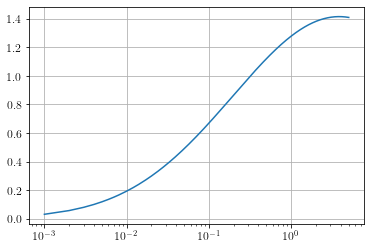

In [243]:
plt.semilogx(Fo,X)
plt.grid()

In [228]:
Fo*np.exp(0.246196- 0.84878*np.log(Fo)- 0.05639*(np.log(Fo))**2)

array([1.41555471, 1.41555471, 1.41555514, 1.41555514, 1.41555471,
       1.41555471, 1.41555514, 1.41555471, 1.41555471, 1.41555514,
       1.41555471, 1.41555471, 1.41555514, 1.41555514, 1.41555471,
       1.41555471, 1.41555471, 1.41555471, 1.41555471, 1.41555471,
       1.41555471, 1.41555471, 1.41555471, 1.41555514, 1.41555471,
       1.41555514, 1.41555514, 1.41555514, 1.41555471, 1.41555514,
       1.41555514, 1.41555471, 1.41555514, 1.41555514, 1.41555514,
       1.41555514, 1.41555514, 1.41555514, 1.41555514, 1.41555514,
       1.41555471, 1.41555471, 1.41555471, 1.41555471, 1.41555514,
       1.41555514, 1.41555514, 1.41555514])

In [223]:
X

array([1.41555471, 1.41555471, 1.41555514, 1.41555514, 1.41555471,
       1.41555471, 1.41555514, 1.41555471, 1.41555471, 1.41555514,
       1.41555471, 1.41555471, 1.41555514, 1.41555514, 1.41555471,
       1.41555471, 1.41555471, 1.41555471, 1.41555471, 1.41555471,
       1.41555471, 1.41555471, 1.41555471, 1.41555514, 1.41555471,
       1.41555514, 1.41555514, 1.41555514, 1.41555471, 1.41555514,
       1.41555514, 1.41555471, 1.41555514, 1.41555514, 1.41555514,
       1.41555514, 1.41555514, 1.41555514, 1.41555514, 1.41555514,
       1.41555471, 1.41555471, 1.41555471, 1.41555471, 1.41555514,
       1.41555514, 1.41555514, 1.41555514])

In [181]:
C_H = zeros(len(L))
C_L = zeros(len(L))
dT_mg = zeros(len(L))
dT_dmg = zeros(len(L))
CdT_mg = zeros(len(L))
CdT_dmg = zeros(len(L))

for i in range(len(L)):
    print(i)
    C_H[i],C_L[i],dT_mg[i],dT_dmg[i],CdT_mg[i],CdT_dmg[i] = Metrics (SpecHeat,dTad,0,B[i],T_arg,N_ml,T_h[i],T_c[i],T_l,T_layer[i][0],L_layer[i][0])

Porous Medium Eff

In [182]:
def Prop_param(X):
    T_c,T_h,B = X
    C_H = 1.65161038/100*T_c+2.59946197*T_h-1.14324309*100*B
    C_L = 10.16443738*T_c-5.32568341*T_h-0.71305997*B
    dT_mg = -0.01057708*T_c+0.01163704*T_h+1.73509682*B
    dT_dmg = -0.01229483*T_c+0.01376157*T_h+0.76454655*B
    CdT_mg = -9.517569*T_c+11.49711993*T_h+820.04168503*B
    CdT_dmg = 4.39480124*T_c-7.07931118/10*T_h+9.15928168*100*B
    return(C_H,C_L,dT_mg,dT_dmg,CdT_mg,CdT_dmg)

In [183]:
for i in range(len(L)):
    print(i)
    C_H[i],C_L[i],dT_mg[i],dT_dmg[i],CdT_mg[i],CdT_dmg[i] = Prop_param((T_c[i],T_h[i],B[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [124]:
def Prop(X,a,b,c): 
    P1,P2,P3= X
    return (a*P1+b*P2+c*P3)

Coef_Ch = curve_fit(Prop,(T_c,T_h,B),Pp,maxfev=10000)
Coef_Ch

err = np.arange(min(Pp),max(Pp),(max(Pp)-min(Pp))/100)
plt.plot(Pp,Prop((T_c,T_h,B),Coef_Ch[0][0],Coef_Ch[0][1],Coef_Ch[0][2]),'o')
plt.plot(err,err*1.01,'k')
plt.plot(err,err*0.99,'k')

Erro = abs(Pp - Prop((T_c,T_h,B),Coef_Ch[0][0],Coef_Ch[0][1],Coef_Ch[0][2]))/Pp*100
plt.plot(T_c-273,Erro,'o')

In [125]:
NTU_f  = h_int*Beta*(L*W*H*10**(-9))/(m_f*c_f) 


Eff = Data.sheet_by_name('Eff') 

Effect = []

for i in range(7):
     Effect.append(array(Eff.col_values(i)))

phi = np.arange(0.1,2.01,0.1)
NTU = np.arange(50,351,50)
NN,PP = np.meshgrid(NTU,phi)

Effectiv = interpolate.interp2d(phi,NTU,Effect,kind = 'linear')

Model Parameters - Similarity

In [126]:
DT_ad = np.log((dT_mg + T_h)/T_c)*dT_mg

In [127]:
Pi_1 = k_s_eff*(T_h-T_c)/(rho_s*f*L**2*CdT_dmg)
Pi_2 = Epsilon/(1-Epsilon)*k_f_eff*(T_h-T_c)/(rho_s*f*L**2*CdT_dmg)
Pi_3 = W_p/(m_s*f*CdT_dmg)
Pi_4 = CdT_mg/CdT_dmg
Pi_5 = h_int*Beta/(f*rho_s*CdT_dmg) #dT_sf unknown
Pi_6 = ((m_f)*c_f)/(m_s*C_L*f)
Pi_7 = (T_h-T_c)/(dT_dmg)
Pi_11 = ((m_f)*c_f)/(m_s*C_H*f)
Pi_12 = dT_dmg/dT_mg

Pi_8 = Q_c/(m_s*f*CdT_dmg)
Pi_9 = Q_h/(m_s*f*CdT_dmg)
Pi_10 = W_m/(m_s*f)

Efness_HB = zeros(len(Pi_6))
Efness_CB = zeros(len(Pi_6))

for i in range(len(Pi_6)):
    Efness_HB[i] = Effectiv(Pi_6[i]/2,NTU_f[i])
    Efness_CB[i] = Effectiv(Pi_11[i]/2,NTU_f[i])

Model Parameters - Integral

In [128]:
FE = 0.25
Q_pas_CB = Efness_CB*(T_h - T_c)*m_f*FE*c_f
Q_act_CB = dT_mg*m_f*c_f*FE

Q_pas_HB = Efness_HB*(T_h - T_c)*m_f*FE*c_f
Q_act_HB = dT_dmg*m_f*c_f*FE

Q_span = (T_h - T_c)*m_f*c_f*FE
Q_cond = ((1-Epsilon)*k_s_eff + Epsilon*k_f_eff)*(W*H*10**-6)*(T_h-T_c)/L
W_mag  = m_s*f*(CdT_mg - CdT_dmg)

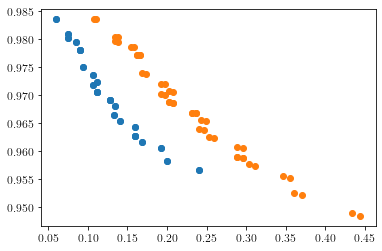

In [129]:
plt.plot(Pi_6/2,Efness_HB,'o')
plt.plot(Pi_11/2,Efness_CB,'o')

In [130]:
def fit_sim(X,a,b,c,d,e,f): 
    P1,P2,P3= X
    return (a*P1**b*P2**c*P3**d + 0*e*P2**f)

In [131]:
def fit_sim1(X,a,b,c,d,e): 
    P1,P2= X
    return ((a*(P1**b)*P2**c)+d*(P1*P2)**e)

In [132]:
def fit_int(X,a,b,c,d,e): 
    P1,P2,P3,P4,P5= X
    return (a*P1+b*P2+c*P3+d*P4+e*P5)

In [133]:
def fit_int_h(X,a,b,c,d,e): 
    P1,P2,P3,P4,P5= X
    return (a*P1+b*P2+c*P3+d*P4+e*P5)

In [134]:
import scipy.integrate as integrate
DTT = np.zeros(len(dT_mg))
for i in range(len(dT_mg)):
    T_int = np.arange(T_c[i],T_h[i]+0.01,0.1)
    dT_med = (dT_mg + dT_dmg)/2
    DTT[i] = integrate.simps(dT_med[i]*np.log(1+dT_med[i]/T_int),T_int)

In [164]:
DT_ad = np.log((dT_mg + T_h)/T_c)*dT_mg
Pi_6 = ((m_f)*c_f)/(m_s*C_L*f)
Pi_7 = (T_h-T_c)/(dT_dmg)

Pi_10 = W_m/(m_s*f*(C_L-C_H)*(T_h - T_c))
Pi_11 = ((m_f)*c_f)/(m_s*C_H*f)
Pi_12 = dT_dmg/dT_mg
K = (C_L-C_H)*(T_h - T_c)

In [195]:
def fit_sim(X,a,b,c,d,e): 
    P1,P2,P3= X
    return ((a*P1**b+c*(P2)**d)*P3**e)

In [196]:
a =3
b = 48

In [198]:
Coef_sim = curve_fit(fit_sim,(Pi_6[a:b],Pi_11[a:b],K[a:b]),Pi_10[a:b],maxfev=10000000,bounds = ([-10,-10,-10,-10,-10],[10,10,10,10,10]))
Coef_sim

(array([-0.72626893,  0.53559307,  0.57854937,  0.54261127, -0.36988939]),
 array([[ 1.71026190e+05, -3.24536455e+02, -1.35881017e+05,
         -2.68119288e+02,  2.37891203e+04],
        [-3.24536455e+02,  6.88539459e-01,  2.57824544e+02,
          5.76003598e-01, -4.51456570e+01],
        [-1.35881017e+05,  2.57824544e+02,  1.07958037e+05,
          2.13002461e+02, -1.89005536e+04],
        [-2.68119288e+02,  5.76003598e-01,  2.13002461e+02,
          4.82495911e-01, -3.72979555e+01],
        [ 2.37891203e+04, -4.51456570e+01, -1.89005536e+04,
         -3.72979555e+01,  3.30898030e+03]]))

In [199]:
W_mag = (m_s*f*(C_L-C_H)*(T_h - T_c))*fit_sim((Pi_6,Pi_11,K),Coef_sim[0][0],Coef_sim[0][1],Coef_sim[0][2],Coef_sim[0][3],Coef_sim[0][4])

In [200]:
Coef = curve_fit(fit_int,(Q_pas_CB[a:b],Q_act_CB[a:b],Q_span[a:b],W_mag[a:b],W_p[a:b]),Q_c[a:b],maxfev=10000, bounds = ([0,0,-1,-10,-10],[10,10,0,2,0]))
Coef

(array([ 0.57988936,  0.99809919, -0.60570427, -3.62234759, -0.90889504]),
 array([[ 6.96548947e-03,  1.05829269e-02, -7.28355927e-03,
         -7.72378141e-02, -8.41410327e-04],
        [ 1.05829269e-02,  1.82040228e-02, -1.12049172e-02,
         -1.26681905e-01, -2.37021044e-03],
        [-7.28355927e-03, -1.12049172e-02,  7.62720837e-03,
          8.11405946e-02,  9.19884473e-04],
        [-7.72378141e-02, -1.26681905e-01,  8.11405946e-02,
          9.26380413e-01,  1.70928167e-02],
        [-8.41410327e-04, -2.37021044e-03,  9.19884473e-04,
          1.70928167e-02,  1.51426592e-03]]))

In [201]:
Coef_h = curve_fit(fit_int_h,(Q_pas_HB[a:b],Q_act_HB[a:b],Q_span[a:b],W_mag[a:b],W_p[a:b]),Q_h[a:b],maxfev=10000, bounds = ([0,0,-100,-10,0],[5,100,0,10,100]))
Coef_h

(array([ 0.47594347,  1.63786144, -0.52281481, -0.52841165,  0.08030101]),
 array([[ 0.0175807 ,  0.0500479 , -0.01907672, -0.16455748, -0.00278865],
        [ 0.0500479 ,  0.1596159 , -0.05511749, -0.50162395, -0.01181953],
        [-0.01907672, -0.05511749,  0.02074151,  0.17976367,  0.0031606 ],
        [-0.16455748, -0.50162395,  0.17976367,  1.64978743,  0.03826055],
        [-0.00278865, -0.01181953,  0.0031606 ,  0.03826055,  0.00265488]]))

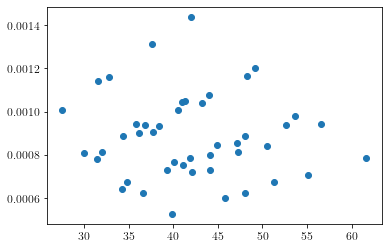

In [202]:
plt.plot(W_mag[a:b],Pi_10[a:b],'o')

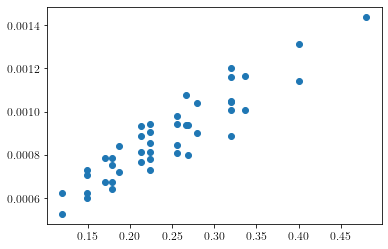

In [203]:
plt.plot(Pi_6[a:b],Pi_10[a:b],'o')

In [204]:
a = 6
b = 48

In [205]:
Error = abs(Q_c[a:b] - fit_int((Q_pas_CB[a:b],Q_act_CB[a:b],Q_span[a:b],W_mag[a:b],W_p[a:b]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3],Coef[0][4]))/(Q_c[a:b])*100
Error_h = abs(Q_h[a:b] - fit_int_h((Q_pas_HB[a:b],Q_act_HB[a:b],Q_span[a:b],W_mag[a:b],W_p[a:b]),Coef_h[0][0],Coef_h[0][1],Coef_h[0][2],Coef_h[0][3],Coef_h[0][4]))/(Q_h[a:b])*100
Error_sim = abs(Pi_10[a:b] - fit_sim((Pi_6[a:b],Pi_11[a:b],K[a:b]),Coef_sim[0][0],Coef_sim[0][1],Coef_sim[0][2],Coef_sim[0][3],Coef_sim[0][4]))/(Pi_10[a:b])*100

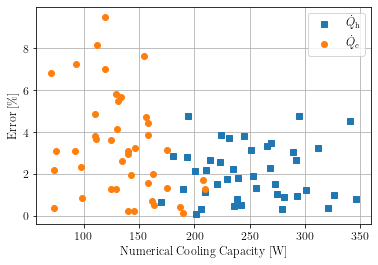

In [206]:
plt.plot(Q_h[a:b],Error_h,'s', label = '$\dot{Q}_\mathrm{h}$')
plt.plot(Q_c[a:b],Error,'o',label ='$\dot{Q}_\mathrm{c}$' )
#plt.plot(Pi_6[a:b],Error_sim,'o',label ='$\dot{Q}_\mathrm{c}$' )

plt.grid()
plt.xlabel('Numerical Cooling Capacity [W]')
plt.ylabel('Error [\%]')
plt.legend()
#plt.ylim(0,50)
#plt.xlim(150,300)

#plt.ylim([0,50])
plt.savefig('Erro_Rest.png',format = 'png', dpi=500,bbox_inches='tight')
plt.show()

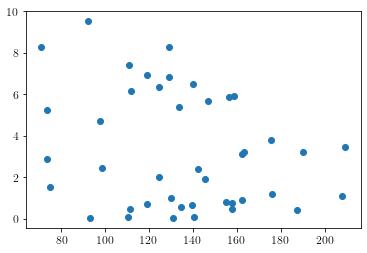

In [207]:
plt.plot(Q_c[a:b],Error_sim,'o')

In [42]:
K = 0
for i in range(len(Error_sim)):
    if Error_sim[i] > 13:
        K = K+1
K/len(Error_sim)*100

0.0

In [319]:
plt.plot(W_m[a:b],(m_s[a:b]*f[a:b]*CdT_dmg[a:b])*fit_sim((Pi_6[a:b],Pi_4[a:b],Pi_11[a:b]),Coef_sim[0][0],Coef_sim[0][1],Coef_sim[0][2],Coef_sim[0][3],Coef_sim[0][4],Coef_sim[0][5]),'o',label ='Integral' )

IndexError: index 5 is out of bounds for axis 0 with size 5

In [1244]:
erro= np.arange(100,230,1)
erro_h= np.arange(100,275,1)

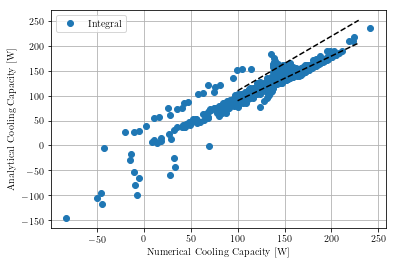

In [1245]:
#plt.plot(Q_c[a:b],m_s[a:b]*f[a:b]*CdT_dmg[a:b]*fit_sim((Pi_6[a:b],Pi_4[a:b]),Coef_sim[0][0],Coef_sim[0][1],Coef_sim[0][2],Coef_sim[0][3]),'s', label = 'Similarity')
plt.plot(Q_c[a:b],fit_int((Q_pas_CB[a:b],Q_act_CB[a:b],Q_span[a:b],W_mag[a:b],W_p[a:b]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3],Coef[0][4]),'o',label ='Integral' )
plt.plot(erro,0.9*erro,'k--')
plt.plot(erro,1.1*erro,'k--')
plt.grid()
plt.ylabel('Analytical Cooling Capacity [W]')
plt.xlabel('Numerical Cooling Capacity [W]')
plt.legend()

plt.savefig('ErrorBar.png',format = 'png', dpi=500,bbox_inches='tight')
plt.show()

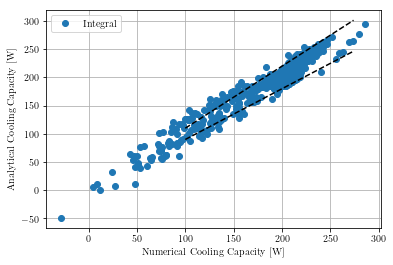

In [1246]:
#plt.plot(Q_c[a:b],m_s[a:b]*f[a:b]*CdT_dmg[a:b]*fit_sim((Pi_6[a:b],Pi_4[a:b]),Coef_sim[0][0],Coef_sim[0][1],Coef_sim[0][2],Coef_sim[0][3]),'s', label = 'Similarity')
plt.plot(Q_h[a:b],fit_int((Q_pas_HB[a:b],Q_act_HB[a:b],Q_span[a:b],W_mag[a:b],W_p[a:b]),Coef_h[0][0],Coef_h[0][1],Coef_h[0][2],Coef_h[0][3],Coef_h[0][4]),'o',label ='Integral' )
plt.plot(erro_h,0.9*erro_h,'k--')
plt.plot(erro_h,1.1*erro_h,'k--')
plt.grid()
plt.ylabel('Analytical Cooling Capacity [W]')
plt.xlabel('Numerical Cooling Capacity [W]')
plt.legend()

plt.savefig('ErrorBar.png',format = 'png', dpi=500,bbox_inches='tight')
plt.show()

In [ ]:
plt.plot(Q_c[a:b],m_s[a:b]*f[a:b]*CdT_dmg[a:b]*fit_sim((Pi_6[a:b],Pi_4[a:b]),Coef_sim[0][0],Coef_sim[0][1],Coef_sim[0][2],Coef_sim[0][3]),'o')
plt.plot(erro,0.9*erro,'k--')
plt.plot(erro,1.1*erro,'k--')
plt.ylabel('Integral Cooling Capacity [W]')
plt.xlabel('Numerical Cooling Capacity [W]')
#plt.legend()
plt.show()
plt.savefig('X_l.pdf',format = 'pdf', dpi=500,bbox_inches='tight')

In [ ]:
plt.plot(Pi_6[0:72],Pi_10[0:72],'o',label = 'B = 1.1 T')
plt.plot(Pi_6[72:144],Pi_10[72:144],'o',label = 'B = 1.3 T')
plt.plot(Pi_6[144:216],Pi_10[144:216],'o',label = 'B = 1.5 T')
plt.plot(Pi_6[216:288],Pi_10[216:288],'o',label = 'B = 1.6 T')
plt.grid()
plt.xlabel('$\phi$ [-]')
plt.ylabel('$\dot{W}_\mathrm{M}^*$ [-]')
plt.legend()
plt.show()

In [ ]:
plt.plot(Pi_6[0:72],Pi_9[0:72],'o',label = 'B = 1.1 T')
plt.plot(Pi_6[72:144],Pi_9[72:144],'o',label = 'B = 1.3 T')
plt.plot(Pi_6[144:216],Pi_9[144:216],'o',label = 'B = 1.5 T')
plt.plot(Pi_6[216:288],Pi_9[216:288],'o',label = 'B = 1.6 T')
plt.grid()
plt.xlabel('$\phi$ [-]')
plt.ylabel('$\dot{Q}_\mathrm{H}^*$ [-]')
plt.legend()
plt.show()

In [ ]:
a = 0*72
b = 4*72

In [ ]:
Coef_Wm = curve_fit(fitting_W,(Pi_6[a:b],Pi_4[a:b]),Pi_10[a:b],maxfev=10000)
Coef_Wm

In [ ]:
plt.plot(Pi_6[a:b],Pi_8[a:b],'o')
plt.plot(Pi_6[a:b],fitting((Pi_6[a:b],Pi_4[a:b]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'o')

In [ ]:
plt.plot(Pi_6[a:b],Pi_9[a:b],'o')
plt.plot(Pi_6[a:b],fitting((Pi_6[a:b],Pi_4[a:b]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'o')

In [ ]:
plt.plot(Pi_6[a:b],Pi_10[a:b],'o')
plt.plot(Pi_6[a:b],fitting_W((Pi_6[a:b],Pi_4[a:b]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],0,Coef_Wm[0][4]),'o')

In [ ]:
erro1 = abs((Pi_8 - fitting((Pi_6[a:b],Pi_4[a:b]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]))/Pi_8*100)
erro2 = abs((Pi_9 - fitting((Pi_6[a:b],Pi_4[a:b]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]))/Pi_9*100)
erro3 = abs((Pi_10 - fitting_W((Pi_6[a:b],Pi_4[a:b]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]))/Pi_10*100)
j=0
h=0
k=0
for i in range(len(erro1)):
    if erro1[i] >= 10:
        j = j+1
    if erro2[i] >= 10:
        h = h+1
    if erro3[i] >= 10:
        k = k+1
j/len(erro1),h/len(erro2),k/len(erro3)

In [ ]:
plt.plot(Pi_6,Q_c,'o')

In [ ]:
plt.plot(Pi_6,erro1,'o')
plt.ylim([0,25])

In [ ]:
plt.plot(Pi_6,erro1,'o',label = '$\dot{Q}_\mathrm{C}$')
plt.plot(Pi_6,erro2,'o',label = '$\dot{Q}_\mathrm{H}$')
plt.plot(Pi_6,erro3,'o',label = '$\dot{W}_\mathrm{M}$')
plt.ylim(0,30)
plt.xlabel('$\phi$ [-]')
plt.legend()
plt.ylabel('Error [$\%$]')
plt.grid()

In [ ]:
plt.plot(Pi_6,erro3,'o')

In [ ]:
plt.plot(Pi_8,fitting((Pi_6,Pi_7),Coef[0][0],Coef[0][1],Coef[0][2]),'o')
plt.plot(Pi_8,0.9*Pi_8)
plt.plot(Pi_8,1.1*Pi_8)
plt.grid()

In [ ]:
error_bar = np.arange(0,700)

In [ ]:
K = (m_s*f*CdT_dmg)
plt.plot(Pi_8[0:72]*K[0:72],K[0:72]*fitting((Pi_6[0:72],Pi_4[0:72]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'o', label = 'B = 1.1 T')
plt.plot(Pi_8[72:2*72]*K[72:2*72],K[72:2*72]*fitting((Pi_6[72:2*72],Pi_4[72:2*72]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'X', label = 'B = 1.3 T')
plt.plot(Pi_8[2*72:3*72]*K[2*72:3*72],K[2*72:3*72]*fitting((Pi_6[2*72:3*72],Pi_4[2*72:3*72]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'s', label = 'B = 1.5 T')
plt.plot(Pi_8[3*72:4*72]*K[3*72:4*72],K[3*72:4*72]*fitting((Pi_6[3*72:4*72],Pi_4[3*72:4*72]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'^', label = 'B = 1.6 T')
plt.plot(error_bar,0.92*error_bar,'k--')
plt.plot(error_bar,1.08*error_bar,'k--')
plt.text(100,80,'- 8\%')
plt.text(80,110,'+ 8\%')


plt.xlabel('Numerical Cooling Capacity [W]')
plt.ylabel('Fitting Cooling Capacity [W]')

plt.grid()
plt.legend()
plt.xlim(0,180)
plt.ylim(0,180)

In [ ]:
plt.plot((Pi_9*K)[0:72],K[0:72]*fitting((Pi_6[0:72],Pi_4[0:72]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'o', label = 'B = 1.1 T')
plt.plot((Pi_9*K)[72:2*72],K[72:144]*fitting((Pi_6[72:2*72],Pi_4[72:2*72]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'X', label = 'B = 1.3 T')
plt.plot((Pi_9*K)[2*72:3*72],K[144:216]*fitting((Pi_6[2*72:3*72],Pi_4[2*72:3*72]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'s', label = 'B = 1.5 T')
plt.plot((Pi_9*K)[3*72:4*72],K[216:288]*fitting((Pi_6[3*72:4*72],Pi_4[3*72:4*72]),Coef_Qh[0][0],Coef_Qh[0][1],Coef_Qh[0][2],Coef_Qh[0][3]),'^', label = 'B = 1.6 T')
plt.plot(error_bar,0.9*error_bar,'k--')
plt.plot(error_bar,1.1*error_bar,'k--')
plt.text(300,230,'- 10\%')
plt.text(250,350,'+ 10\%')


plt.xlabel('Numerical Rejected Heat [W]')
plt.ylabel('Fitting Rejected Heat [W]')

plt.grid()
plt.legend()
plt.xlim(20,550)
plt.ylim(20,550)

In [ ]:
plt.plot((Pi_10*K)[0:72],K[0:72]*fitting_W((Pi_6[0:72],Pi_4[0:72]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]),'o', label = 'B = 1.1 T')
plt.plot((Pi_10*K)[72:2*72],K[72:144]*fitting_W((Pi_6[72:2*72],Pi_4[72:2*72]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]),'X', label = 'B = 1.3 T')
plt.plot((Pi_10*K)[2*72:3*72],K[144:216]*fitting_W((Pi_6[2*72:3*72],Pi_4[2*72:3*72]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]),'s', label = 'B = 1.5 T')
plt.plot((Pi_10*K)[3*72:4*72],K[216:288]*fitting_W((Pi_6[3*72:4*72],Pi_4[3*72:4*72]),Coef_Wm[0][0],Coef_Wm[0][1],Coef_Wm[0][2],Coef_Wm[0][3],Coef_Wm[0][4]),'^', label = 'B = 1.6 T')
plt.plot(error_bar,0.9*error_bar,'k--')
plt.plot(error_bar,1.1*error_bar,'k--')
plt.text(40,31.5,'- 8\%')
plt.text(31.5,45,'+ 8\%')


plt.xlabel('Numerical Magnetic Work[W]')
plt.ylabel('Fitting Magnetic Work [W]')

plt.grid()
plt.legend()
plt.xlim(5,70)
plt.ylim(5,70)